In [1]:
#imports
import katdal
import numpy as np
import matplotlib.pylab as plt
import astropy.coordinates as ac
import functools
import healpy as hp
import optparse
import warnings
from matplotlib.backends.backend_pdf import PdfPages
import healpy as hp
from astropy import units as u
from matplotlib.offsetbox import AnchoredText
import time
import pickle
import sys
import katcali
import katcali.visualizer as kv
import katcali.models as km
import katcali.rfi as kr
import katcali.solver as ks
import katcali.io as kio
import katcali.label_dump as kl
import katcali.diode as kd
import katcali.filter as kf
import katcali.beam as kb
from astropy.coordinates import SkyCoord
from astropy import units as u
from scipy.sparse import coo_matrix
import astropy.wcs
from astropy.wcs.utils import skycoord_to_pixel
from astropy.wcs.utils import pixel_to_skycoord
from astropy.io import fits
from astropy.wcs import WCS
from scipy.interpolate import UnivariateSpline
import matplotlib.colors as colors
Tcmb=2.725
k_B = 1.38E-23

In [2]:
print 'start @ ' + time.asctime(time.localtime(time.time())) +'...'

start @ Wed Jun  8 15:32:04 2022...


In [3]:
print  plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth']
plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth'] = 14, 1.5, 1.5
#plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth'] = 10.0, 0.8, 1.5
print  plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth']

10.0 0.8 1.5
14.0 1.5 1.5


In [4]:
pix_deg=0.3 #0.15 #0.3
std_sigma=2.5 #the smaller number will make more data be delated 

ch_plot=800

In [5]:
p_radec=np.loadtxt('radio_source2021.txt')
ptr_pix=np.loadtxt('radio_source2021_pix_'+str(pix_deg)+'deg.txt')
ptr_ra_pix,ptr_dec_pix=ptr_pix[:,0],ptr_pix[:,1]
input_file='/idia/projects/hi_im/raw_vis/MeerKLASS2021/level5/data/'
output_file='./'

In [6]:
fname_list=['1630519596','1631379874','1631387336','1631552188','1631559762','1631659886',
            '1631667564','1631724508','1631732038','1631810671','1631818149','1631982988',
            '1631990463','1632069690','1632077222','1632184922','1632505883','1632760885',
            '1633365980','1633970780','1634252028','1634402485','1634748682','1634835083',
            '1637346562','1637354605','1637691677','1637699408','1638130295','1638294319',
            '1638301944','1638386189','1638639082','1638647186','1638898468','1639157507',
            '1639331184','1639935088','1640540184','1640712986','1640799689']



# try to load merged but unfiltered data

In [7]:
total_count_MAX=1339

niter=1 # no filter applied

>>>>>>>>> Iteration 0 start...
*** No previous data cube with label *ALL_scan*, calculate ALL_scan now... will stop after ALL_scan calculated 
-------------------------------------------
-------------------------------------------
***stastic cubes initialized
# cube 1: 1630519596 m000
### no ch_drop!
no data cube for 1631379874, m000
no data cube for 1631387336, m000
no data cube for 1631552188, m000
# cube 2: 1631559762 m000
### no ch_drop!
# cube 3: 1631659886 m000
### no ch_drop!
# cube 4: 1631667564 m000
### no ch_drop!
no data cube for 1631724508, m000
no data cube for 1631732038, m000
no data cube for 1631810671, m000
no data cube for 1631818149, m000
no data cube for 1631982988, m000
no data cube for 1631990463, m000
no data cube for 1632069690, m000
# cube 5: 1632077222 m000
### no ch_drop!
no data cube for 1632184922, m000
no data cube for 1632505883, m000
no data cube for 1632760885, m000
# cube 6: 1633365980 m000
### no ch_drop!
no data cube for 1633970780, m000
# cube 7: 16

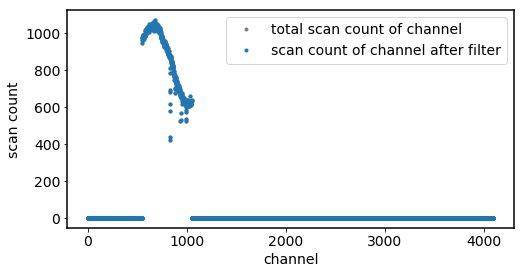

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:263: RuntimeWarning: invalid value encountered in divide
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:264: RuntimeWarning: invalid value encountered in divide


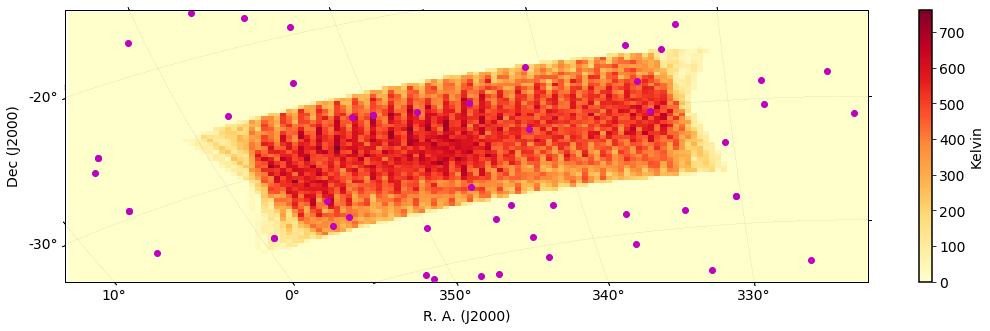

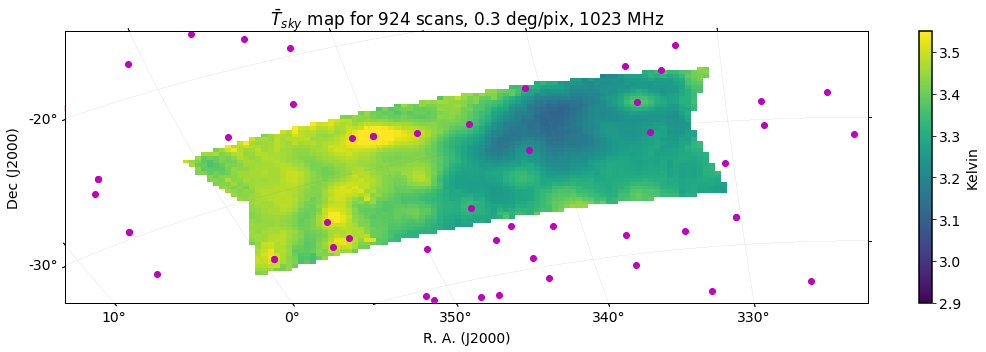

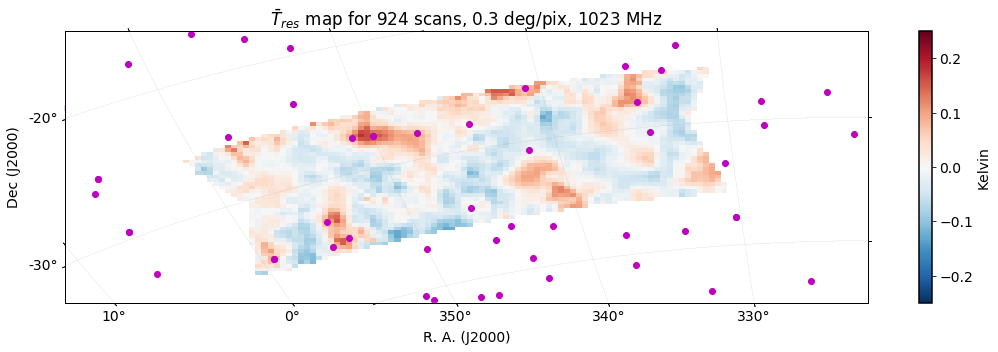

1339
ALL_scan finished, will EXIT soon ...
ALL_scan finished, will EXIT soon ...
ALL_scan finished, will EXIT soon ...
ALL_scan finished, will EXIT soon ...
ALL_scan finished, will EXIT soon ...
ALL_scan finished, will EXIT soon ...


In [8]:
pix_ma_ra=[]
pix_ma_dec=[]

for i_iter in range(niter):
    print '>>>>>>>>> Iteration '+str(i_iter)+' start...'
    
    ####load previous data in########
    try:
        if i_iter==0:#First
            Fits=output_file+'ALL_scan'+str(total_count_MAX)+'_Tresi_cube_p'+str(pix_deg)+'d.fits'
            Tresi_cube = fits.open(Fits)[0].data
            print np.shape(Tresi_cube)
            #only need to load once###
            Npix_x= np.shape(Tresi_cube)[0]
            Npix_y= np.shape(Tresi_cube)[1]

            w2=WCS(Fits).dropaxis(-1)
            print w2
            
            ####mask point sources######    
            map_ra=np.zeros_like(Tresi_cube[:,:,ch_plot])
            map_dec=np.zeros_like(Tresi_cube[:,:,ch_plot])
            for i in range(np.shape(map_ra)[0]):
                for j in range(np.shape(map_ra)[1]):
                    radec=pixel_to_skycoord(i,j,w2)
                    map_ra[i,j]=radec.ra.deg
                    map_dec[i,j]=radec.dec.deg
            p = SkyCoord(map_ra*u.deg,  map_dec*u.deg, frame='icrs')

            for s in range(len(p_radec)):
                p_ra,p_dec=p_radec[s]
                c = SkyCoord(p_ra*u.deg,  p_dec*u.deg, frame='icrs')
                p_ang=(c.separation(p)/u.deg)
                dp_l=np.where(p_ang<1.)
                dp_l=np.array(dp_l)
                pix_ma_ra+=list(dp_l[0])
                pix_ma_dec+=list(dp_l[1])
                
        if i_iter>0: #Since second
            Fits=output_file+'Nscan'+str(total_count)+'_Tresi_cube_p'+str(pix_deg)+'d_sigma'+str(std_sigma)+'_iter'+str(i_iter-1)+'.fits'
                            
        Tresi_cube = fits.open(Fits)[0].data
        print np.shape(Tresi_cube)

        plt.figure(figsize=(18,5))
        ax=plt.subplot(projection=w2)
        plt.imshow(Tresi_cube[:,:,ch_plot].T,cmap='jet',aspect='auto')
        plt.plot(ptr_ra_pix,ptr_dec_pix,'mo')
        #plt.plot(ptr_ra_pix[22],ptr_dec_pix[22],'mo',ms=12)
        plt.colorbar(label='Kelvin')
        plt.xlabel('R. A. (J2000)')
        plt.ylabel('Dec (J2000)')
        plt.xlim([0,Npix_x])
        plt.ylim([0,Npix_y])
        ax.invert_xaxis()
        plt.title('reloaded data')
        plt.show()

        print np.nanmin(Tresi_cube[:,:,ch_plot]),np.nanmax(Tresi_cube[:,:,ch_plot]) 

        Tresi_cube1=Tresi_cube.copy()
        Tresi_cube1[pix_ma_ra,pix_ma_dec,:]=np.nan
        print np.nanmean(Tresi_cube1[:,:,ch_plot]),np.nanstd(Tresi_cube1[:,:,ch_plot]) 

        plt.figure(figsize=(18,5))
        ax=plt.subplot(projection=w2)
        plt.imshow(Tresi_cube1[:,:,ch_plot].T,cmap='jet',aspect='auto')
        plt.colorbar(label='Kelvin')
        plt.xlabel('R. A. (J2000)')
        plt.ylabel('Dec (J2000)')
        plt.xlim([0,Npix_x])
        plt.ylim([0,Npix_y])
        ax.invert_xaxis()
        plt.show()
 
        ######calculate std without point sources################
        Tresi_ra_std=np.nanstd(Tresi_cube1,axis=0)
        Tresi_ra_mean=np.nanmean(Tresi_cube1,axis=0)

        Tresi_ra_u=Tresi_ra_mean+std_sigma*Tresi_ra_std
        Tresi_ra_l=Tresi_ra_mean-std_sigma*Tresi_ra_std

        x_ticks=pixel_to_skycoord(0,range(np.shape(Tresi_cube)[1]),w2).dec/u.deg #pix_ra=0, get dec
        x_ticks=np.array(x_ticks)
        assert(np.shape(Tresi_cube)[1]==len(x_ticks))
        
        plt.figure(figsize=(8,4))
        plt.plot(Tresi_ra_mean[:,ch_plot],'r')
        plt.plot(Tresi_ra_u[:,ch_plot],'b--')
        plt.plot(Tresi_ra_l[:,ch_plot],'g--')
        
        tick_i=[0, 10, 20, 30, 40]
        plt.xticks(tick_i, np.round(x_ticks[tick_i],1))
        plt.xlabel('${Dec_{pix}}$ (Deg)')
        plt.ylabel('T (K)')
        plt.legend(['mean','mean+3sigma','mean-3sigma'],ncol=3)
        plt.title('$T_{res}$ along dec of ch'+str(ch_plot)+', all scans')
        plt.grid(color='grey', lw=.1)
        plt.savefig('Tresi_filter_iter'+str(i_iter)+'.pdf', bbox_inches='tight')
        plt.show()

    except IOError:
        if i_iter==0:#First
            print '*** No previous data cube with label *ALL_scan*,',
            print 'calculate ALL_scan now...',
            print 'will stop after ALL_scan calculated '
            Fits=input_file+fname_list[0]+'_m000_Tresi_xy_p'+str(pix_deg)+'d.fits'
            Tresi_cube = fits.open(Fits)[0].data
            Tresi_ra_u=np.ones_like(Tresi_cube[0,:,:])*1e3
            Tresi_ra_l=np.ones_like(Tresi_cube[0,:,:])*-1e3
        else:
            print '*** No data cube for iter '+str(i_iter-1)+', EXIT!'
            break
            
    #######filter data##########################
    n_ch_del=0
    n_ch_keep=0
    total_count=0 #cube count
    total_count_plot=0 #channel count
    total_count_list=np.zeros(4096)

    for a_i in range(64):
        ant='m'+ "%03d" % a_i
        #print ant

        for f_i in range(len(fname_list)):
            fname=fname_list[f_i]
            #print fname

            try:
                #print 'set ch_mask'
                a=np.ma.array(np.zeros(4096),mask=True)
                ch_mask=a.mask
                
                Fits1=input_file+fname+'_'+ant+'_Tsky_xy_p'+str(pix_deg)+'d.fits'
                Tsky_cube = fits.open(Fits1)[0].data
                Fits2=input_file+fname+'_'+ant+'_Tresi_xy_p'+str(pix_deg)+'d.fits'
                Tresi_cube = fits.open(Fits2)[0].data
                Fits3=input_file+fname+'_'+ant+'_Npix_xy_count_p'+str(pix_deg)+'d.fits'
                Pcount_cube = fits.open(Fits3)[0].data
                
                assert(np.shape(Tsky_cube)==np.shape(Tresi_cube))
                assert((np.isnan(Tresi_cube)).all()==False)
                if (np.isnan(Tsky_cube)).all()==False: 
                    total_count+=1 #cube count
                    for ch_ii in range(4096):
                        if (np.isnan(Tsky_cube[:,:,ch_ii])).all()==False:
                            ch_mask[ch_ii]=False
                else:
                    print '***empty cube'

                if (total_count==1):
                    Npix_x= np.shape(Tsky_cube)[0]
                    Npix_y= np.shape(Tsky_cube)[1]

                    w=WCS(Fits1).dropaxis(-1)
                    w2=WCS(Fits2).dropaxis(-1)
                    assert(w.wcs==w2.wcs)
                    print '-------------------------------------------'
                    #print w
                    print '-------------------------------------------'
                    fits_temp=np.zeros([Npix_x,Npix_y,4096])

                    Sum_Tsky_xy=fits_temp.copy()
                    Sum_Tresi_xy=fits_temp.copy()
                    Npix_xy_count1=fits_temp.copy()
                    Npix_xy_count2=fits_temp.copy()
                    P_xy_count1=fits_temp.copy()
                    P_xy_count2=fits_temp.copy()
                    assert((Sum_Tsky_xy==0).all()==True)
                    assert((Sum_Tresi_xy==0).all()==True)
                    assert((Npix_xy_count1==0).all()==True)
                    assert((Npix_xy_count2==0).all()==True)
                    print '***stastic cubes initialized'

                print '# cube '+str(total_count)+': '+fname+' '+ant
                assert(np.shape(Tsky_cube)==np.shape(Sum_Tsky_xy))
                
                if (Tresi_ra_u==1000).all()==True:
                    print '### no ch_drop!'
                else:
                    #'''
                    #mean along dec to check rfi lines
                    Tresi_cube1=Tresi_cube.copy()
                    Tresi_cube1[pix_ma_ra,pix_ma_dec,:]=np.nan
                    Tresi_ra_median=np.nanmedian(Tresi_cube1,axis=0) #always check Tresi since Tsky have the Galactic slope 

                    ch_drop=[]  
                    for ch_i in range(4096):
                        if ((Tresi_ra_median[:,ch_i]<Tresi_ra_l[:,ch_i]).any()==True 
                            or (Tresi_ra_median[:,ch_i]>Tresi_ra_u[:,ch_i]).any()==True):
                            ch_drop.append(ch_i)

                    if len(ch_drop)>0:
                        Tsky_cube[:,:,ch_drop]=np.nan            
                        Tresi_cube[:,:,ch_drop]=np.nan
                        print '***'+str(len(ch_drop))+' channels deleted'
                        n_ch_del+=len(ch_drop)
                        ch_mask[ch_drop]=True
                        
                    ch_l=len(np.where(ch_mask==False)[0])
                    n_ch_keep+=ch_l
                    print '***'+str(ch_l)+' channels left'
                    d1={}
                    d1['ch_mask']=ch_mask
                    fs=open(output_file+str(fname)+'_'+str(ant)+'_level6_p'+str(pix_deg)+'d_sigma'+str(std_sigma)+'_iter'+str(i_iter)+'_mask','wb')
                    pickle.dump(d1,fs,protocol=2)
                    fs.close()
                    #'''    
                Sum_Tsky_xy[~np.isnan(Tsky_cube)]+=Tsky_cube[~np.isnan(Tsky_cube)]
                Sum_Tresi_xy[~np.isnan(Tresi_cube)]+=Tresi_cube[~np.isnan(Tresi_cube)]
                Npix_xy_count1[~np.isnan(Tsky_cube)]+=1
                Npix_xy_count2[~np.isnan(Tresi_cube)]+=1
                P_xy_count1[~np.isnan(Tsky_cube)]+=Pcount_cube[~np.isnan(Tsky_cube)]
                P_xy_count2[~np.isnan(Tresi_cube)]+=Pcount_cube[~np.isnan(Tresi_cube)]
                if (np.isnan(Tsky_cube[:,:,ch_plot])).all()==False: #channel count
                    total_count_plot+=1

                for ch_i in range(550,1051) + range(2150,3101):##set channels
                    if (np.isnan(Tsky_cube[:,:,ch_i])).all()==False: #channel count
                        total_count_list[ch_i]+=1

            except IOError:
                print 'no data cube for '+ fname+', '+ant

    ######check and save data#####
    print n_ch_del
    print 'total channel number left: '+str(n_ch_keep)

    if (Tresi_ra_u==1000).all()==True:
        np.savetxt(output_file+'ALL_scan'+str(total_count)+'_list_p'+str(pix_deg)+'d.dat',total_count_list)
        print 'list for ALL_scan saved'
    else:
        np.savetxt(output_file+'Nscan'+str(total_count)+'_list_p'+str(pix_deg)+'d_sigma'+str(std_sigma)+'_iter'+str(i_iter)+'.dat',total_count_list)
        print 'list for Iter'+str(i_iter)+' saved'
        
    assert(total_count_list[ch_plot]==total_count_plot)

    m=np.where(total_count_list==total_count_list.max())
    print m,total_count_list[m]

    plt.figure(figsize=(8,4))
    #plt.plot(total_count_list,'.')
    ###plt.plot(ch_plot,total_count_plot,'r*')
    ###plt.plot(m,total_count_list[m],'g*')
    plt.xlabel('channel')
    plt.ylabel('scan count')
    try:
        total_count_list0=np.loadtxt(output_file+'ALL_scan'+str(total_count)+'_list_p'+str(pix_deg)+'d.dat')
        print total_count_list0
        plt.plot(total_count_list0,'.',color='grey')
        
    except IOError:
        print '*** No previous data cube'
    #plt.legend(['scan count of channel after filter','total scan count of channel'])
    plt.plot(total_count_list,'.')
    plt.legend(['total scan count of channel','scan count of channel after filter'])
    
    if i_iter==niter-1:
        plt.savefig('count_comp_iter'+str(i_iter)+'.pdf', bbox_inches='tight')
    plt.show()

    Tsky_xy=Sum_Tsky_xy/Npix_xy_count1
    Tresi_xy=Sum_Tresi_xy/Npix_xy_count2

    plt.figure(figsize=(18,5))
    ax=plt.subplot(projection=w)
    plt.grid(color='grey',lw=.1)
    plt.imshow(Npix_xy_count1[:,:,ch_plot].T,cmap=kv.cmap3(),aspect='auto')
    plt.plot(ptr_ra_pix,ptr_dec_pix,'mo')
    #plt.plot(ptr_ra_pix[22],ptr_dec_pix[22],'mo',ms=12)
    plt.colorbar(label='Kelvin')
    plt.xlabel('R. A. (J2000)')
    plt.ylabel('Dec (J2000)')
    plt.xlim([0,Npix_x])
    plt.ylim([0,Npix_y])
    ax.invert_xaxis()
    plt.savefig('Ncount'+str(ch_plot)+'_iter'+str(i_iter)+'.png', bbox_inches='tight')
    plt.show()
    
    
    plt.figure(figsize=(18,5))
    ax=plt.subplot(projection=w)
    plt.grid(color='grey',lw=.1)
    plt.imshow(Tsky_xy[:,:,ch_plot].T,cmap=kv.cmap1(),aspect='auto',vmin=2.9,vmax=3.55)
    plt.plot(ptr_ra_pix,ptr_dec_pix,'mo')
    #plt.plot(ptr_ra_pix[22],ptr_dec_pix[22],'mo',ms=12)
    plt.colorbar(label='Kelvin')
    plt.xlabel('R. A. (J2000)')
    plt.ylabel('Dec (J2000)')
    plt.title(r'$\bar T_{sky}$'+' map for '+str(total_count_plot)+' scans, '+str(pix_deg)+' deg/pix, '
                                  +str(int(kio.cal_freq(ch_plot)/1e6))+' MHz')
    plt.xlim([0,Npix_x])
    plt.ylim([0,Npix_y])
    ax.invert_xaxis()
    plt.savefig('F_Tsky_all_ch'+str(ch_plot)+'_iter'+str(i_iter)+'.png', bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(18,5))
    ax=plt.subplot(projection=w)
    plt.grid(color='grey',lw=.1)
    plt.imshow(Tresi_xy[:,:,ch_plot].T,cmap=kv.cmap2(),aspect='auto',vmin=-0.25, vmax=0.25)
    plt.plot(ptr_ra_pix,ptr_dec_pix,'mo')
    #plt.plot(ptr_ra_pix[22],ptr_dec_pix[22],'mo',ms=12)
    #plt.text(ptr_ra_pix[19]-0.8,ptr_dec_pix[19]+0.8,'4C+00.35')    
    
    plt.colorbar(label='Kelvin')
    plt.xlabel('R. A. (J2000)')
    plt.ylabel('Dec (J2000)')
    plt.title(r'$\bar T_{res}$'+' map for '+str(total_count_plot)+' scans, '+str(pix_deg)+' deg/pix, '
                                  +str(int(kio.cal_freq(ch_plot)/1e6))+' MHz')
    plt.xlim([0,Npix_x])
    plt.ylim([0,Npix_y])
    ax.invert_xaxis()
    plt.savefig('F_Tresi_all_ch'+str(ch_plot)+'_iter'+str(i_iter)+'.png', bbox_inches='tight')
    plt.show()

    assert((Npix_xy_count1==Npix_xy_count2).all())
    assert((P_xy_count1==P_xy_count2).all())
    print total_count

    #save data
    list_data=[Sum_Tsky_xy,Sum_Tresi_xy,Npix_xy_count1,Tsky_xy,Tresi_xy, P_xy_count1]
    list_str=['Sum_Tsky_cube','Sum_Tresi_cube','Npix_count_cube','Tsky_cube','Tresi_cube','P_xy_count']
    for i in range(len(list_data)):
        hdu=w.to_fits()
        hdu[0].data=list_data[i]
        #if (std_list0==1000).all()==True:
        if (Tresi_ra_u==1000).all()==True:
            hdu.writeto(output_file+'ALL_scan'+str(total_count)+'_'+list_str[i]+'_p'+str(pix_deg)+'d.fits', overwrite=True)
            print 'ALL_scan finished, will EXIT soon ...'
        else:    
            hdu.writeto(output_file+'Nscan'+str(total_count)+'_'+list_str[i]+'_p'+str(pix_deg)+'d_sigma'+str(std_sigma)+'_iter'+str(i_iter)+'.fits', overwrite=True)


In [10]:
print 'end @ ' + time.asctime(time.localtime(time.time())) +'#'

end @ Wed Jun  8 18:21:41 2022#
